In [5]:
# Import everything from slmcontrol
#from slmcontrol import *
from cameras.Ximea import XimeaCamera
import matplotlib.pyplot as plt
#from partially_coherent_sources import generate_masks
from tqdm import trange
import h5py
import numpy as np
from time import sleep

# Initialize our slm display
#slm = SLMdisplay(monitor=1)
    
# Constructs a grid that is defined by the size and resolution of the SLM
#x, y = build_grid(15.36, 8.64, 1920, 1080)

In [2]:
from juliacall import Main as jl
jl.seval("using SpatialLightModulator, StructuredLight")
slm = jl.SLM()

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [3]:
width = 15.36
height = 8.64
resX = 1920
resY = 1080

x = jl.LinRange(-width / 2, width / 2, resX)
y = jl.LinRange(-height / 2, height / 2, resY)

incoming = jl.hg(y, x, w=2.4)
desired = jl.hg(y, x, w=0.3,n=10, m=10)

holo = jl.generate_hologram(desired, incoming, y, x, 82, 4, 5)
jl.SpatialLightModulator.update_hologram(slm, holo)

1920×1080 Matrix{UInt8}:
 0x18  0x18  0x18  0x18  0x18  0x18  …  0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18  …  0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
    ⋮                             ⋮  ⋱           ⋮                    
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x18  0x18  0x18  0x18  0x18  0x18     0x18  0x18  0x18  0x18  0x18  0x18
 0x1

In [6]:
camera = XimeaCamera()
plt.imshow(camera.capture())
camera.close()

Xi_error: ERROR 57: Resource (device) or function locked by mutex

xiAPI: ---- xiOpenDevice API:V4.29.04.00 started ----
xiAPI: OpenDeviceUSB30 ERROR opening driver - Flag set - device already opened
xiAPI: EAL_IF_xi3API::OpenDeviceHandler failed for id:0
xiAPI: xiAPI error: Expected XI_OK in:../Layers/EAL/EAL_IF_xiFAPI_Top.cpp OpenDeviceHandler/Line:76
xiAPI: OpenDevice Error 57
xiAPI: xiAPI error: Expected XI_OK in:../API/xiFAPI/interfaces/01_top/xifapi_Top.cpp xiOpenDevice/Line:100


In [7]:
#modes = [ for m in range(11)]
results = np.empty((11,1024,1280),np.uint8)
#camera = XimeaCamera()
for n in trange(11):
    holo = jl.generate_hologram(jl.hg(y,x,n=n,w=0.3), incoming, y, x, 82, 4, 5)
    jl.update_hologram(slm, holo)
    #results[n] = camera.capture()
    sleep(1)
#camera.close()

100%|██████████| 11/11 [00:13<00:00,  1.22s/it]


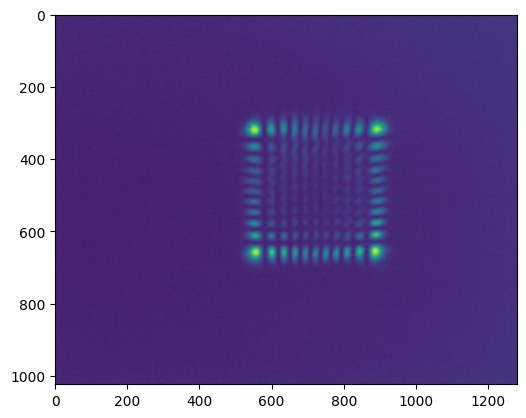

In [11]:
plt.imshow(results[1])

In [ ]:
camera.close()

In [ ]:
# The input beam, which we assme to be a gaussian
incoming = hg(x, y, 0, 0, 2.4)

# The beam that we wish to produce. 
# In this case, a Laguerre-Gaussian with p=0 and l=1
desired = lg(x, y, 0, 0, .2)

# Generates the hologram that will be shown in the SLM
holo = generate_hologram(desired, incoming, x, y, 96, 3, -4, 0, 0)

# Displays the generated hologram
slm.updateArray(holo)

In [ ]:
from juliacall import Main as jl
jl.include("test.jl")

_x = jl.vec(jl.Array(x))
_y = jl.vec(jl.Array(y))
basis = jl.get_basis(_x,_y,2,.2)

In [ ]:
n_masks = 300
masks = generate_masks(n_masks, weights, fields, method='phase_randomized')

In [ ]:
camera = ImagingSourceCamera()

In [ ]:
roi = (626,926,175,475)
plt.imshow(camera.capture(roi))

In [ ]:
with h5py.File("data.h5","w-") as file:
    file["calibration"] = camera.capture(roi)

In [ ]:
n_masks = 150
n_modes = 100
rhos = jl.sample(jl.GinibreEnsamble(2),n_modes)
images = np.empty((n_modes,roi[1]-roi[0],roi[3]-roi[2]))

for m in trange(n_modes):
    fields, weights = jl.get_fields_and_probs(rhos[:,:,m], basis)
    masks = generate_masks(n_masks, weights, fields, method='phase_randomized')

    holo = generate_hologram(masks[0], incoming, x, y, 96, 3, -4, 0, 0)
    for n in trange(n_masks-1):
        slm.updateArray(holo,sleep=0)
        holo = generate_hologram(masks[n+1], incoming, x, y, 96, 3, -4, 0, 0)
        images[m] += camera.capture(roi)
    slm.updateArray(holo)
    images[m] += camera.capture(roi)

with h5py.File("data.h5","w-") as file:
    file["images"] = images
    file["labels"] = rhos

In [ ]:
plt.imshow(images.mean(axis=0))

In [ ]:
plt.imshow(images[1,:,:])

In [ ]:
camera.close()